In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

import sklearn
print('Zainstalowana wersja scikit-learn: {}.'.format(sklearn.__version__))

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams["figure.figsize"] = (20,10) # aby wykresy w Colabie były większe

import numpy as np
from scipy import diag, interp
from itertools import cycle

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import r2_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from termcolor import cprint

import plotly.graph_objects as go

import plotly.express as px

import time

from auxiliary_funcs import *

rs = 42

np.random.seed(rs)
torch.manual_seed(rs);

Zainstalowana wersja scikit-learn: 1.0.2.


In [2]:
def models_comparison_figure(df_nn, plot_name = "NN_viz.pdf"):
    fig, axs = plt.subplots(1, 1, figsize=(12, 10))
    plt.tight_layout(pad=10, h_pad=5, w_pad=0.2)
    fs = 30
    fs_inset = 20
    lw = 3
    colormap = "coolwarm"

    axs.set_xlabel(r"Usable area [m$^2$]", fontsize=fs)
    axs.set_ylabel(r"Predicted usable area [m$^2$]", fontsize=fs)

    axs.set_title("Neural network", fontsize=fs)
    axs.plot(np.linspace(60, 200), np.linspace(60, 200))
    scat2 = axs.scatter(df_nn["Usable area [m2]"], df_nn["Predicted Usable Area [m2]"], c=df_nn.Error, cmap=colormap, marker="")
    norm = plt.Normalize(np.min(df_nn.Error), np.max(df_nn.Error))
    df_1s = df_nn.loc[df_nn["Number of stories"] == 1.0]
    df_2s = df_nn.loc[df_nn["Number of stories"] == 2.0]
    df_ms = df_nn.loc[df_nn["Number of stories"] > 2.0]
    axs.scatter(df_1s["Usable area [m2]"], df_1s["Predicted Usable Area [m2]"], c=df_1s.Error, cmap=colormap, marker="D", norm=norm, s=5*fs)
    axs.scatter(df_2s["Usable area [m2]"], df_2s["Predicted Usable Area [m2]"], c=df_2s.Error, cmap=colormap, marker="o", norm=norm, s=5*fs)
    axs.scatter(df_ms["Usable area [m2]"], df_ms["Predicted Usable Area [m2]"], c=df_ms.Error, cmap=colormap, marker="X", norm=norm, s=5*fs)
    """
    axs[1].text(0.03, 0.96, "R^2 = {:.2f} \nMean Absolute Error = {:.2f}\nMedian Absolute Error = {:.2f}\nMax Error = {:.2f}\nMin Error = {:.2f}\nMedian Absolute Percentage Error = {:.2f}".format(
                                                                                sklearn.metrics.r2_score(df_nn["Usable area [m2]"].to_numpy(), df_nn["Predicted Usable Area [m2]"].to_numpy()), 
                                                                                sklearn.metrics.mean_absolute_error(df_nn["Usable area [m2]"].to_numpy(), df_nn["Predicted Usable Area [m2]"].to_numpy()),
                                                                                sklearn.metrics.median_absolute_error(df_nn["Usable area [m2]"].to_numpy(), df_nn["Predicted Usable Area [m2]"].to_numpy()),
                                                                                sklearn.metrics.max_error(df_nn["Usable area [m2]"].to_numpy(), df_nn["Predicted Usable Area [m2]"].to_numpy()),
                                                                                np.abs(np.min(df_nn["Error"])),
                                                                                sklearn.metrics.mean_absolute_percentage_error(df_nn["Usable area [m2]"].to_numpy(), df_nn["Predicted Usable Area [m2]"].to_numpy())
                                                                                ), bbox=dict(boxstyle="round", fc="lightsalmon", ec="coral", lw=2), horizontalalignment='left', verticalalignment='top', transform=axs[1].transAxes, fontsize=fs_inset);
    """
    axs.set_xlabel(r"Usable area [m$^2$]", fontsize=fs)

    divider = make_axes_locatable(axs)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(scat2, cax=cax)
    cbar.set_label('Error value', fontsize=fs)
    cax.tick_params(axis='both', which='major', labelsize=fs, width=2)


    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
            ax.spines[axis].set_zorder(0)


    axs.tick_params(axis='both', which='major', labelsize=fs, width=2)

    axs.grid(True)

    plt.rc('grid', linestyle=":", color='gray')

    print("R^2 = {:.2f} \nMean Absolute Error = {:.2f}\nMedian Absolute Error = {:.2f}\nMax Error = {:.2f}\nMin Error = {:.2f}\nMedian Absolute Percentage Error = {:.2f}".format(
                                                                                sklearn.metrics.r2_score(df_nn["Usable area [m2]"].to_numpy(), df_nn["Predicted Usable Area [m2]"].to_numpy()), 
                                                                                sklearn.metrics.mean_absolute_error(df_nn["Usable area [m2]"].to_numpy(), df_nn["Predicted Usable Area [m2]"].to_numpy()),
                                                                                sklearn.metrics.median_absolute_error(df_nn["Usable area [m2]"].to_numpy(), df_nn["Predicted Usable Area [m2]"].to_numpy()),
                                                                                sklearn.metrics.max_error(df_nn["Usable area [m2]"].to_numpy(), df_nn["Predicted Usable Area [m2]"].to_numpy()),
                                                                                np.abs(np.min(df_nn["Error"])),
                                                                                sklearn.metrics.mean_absolute_percentage_error(df_nn["Usable area [m2]"].to_numpy(), df_nn["Predicted Usable Area [m2]"].to_numpy())
                                                                                ))
                                                                                
    plt.savefig(plot_name)
    plt.show()

# Dataset Exploration

In [3]:
data_dir = Path("./Gable-roof/")

In [4]:
for f in data_dir.iterdir():
    print(f)

Gable-roof/Archiwalne
Gable-roof/.DS_Store
Gable-roof/ML and usable area.png
Gable-roof/Dwuspady_projektowe.xlsx
Gable-roof/Koszalin_znana_norma.xlsx
Gable-roof/Dwuspady_projektowe_archived.xlsx
Gable-roof/Koszalin_znana_norma-kopia.xlsx
Gable-roof/Koszalin_nieznana_norma.xlsx


## Normalization datasets

In [5]:
curr_file = data_dir.joinpath("Dwuspady_projektowe.xlsx")

In [6]:
curr_file_dict = pd.read_excel(curr_file, sheet_name=None)
curr_file_dict.keys()

dict_keys(['Without garages or boiler rooms', 'Without garages, with boilers', 'With garages and boiler rooms'])

## Normalization dataset 1
Input data: Varying  
Output: Usable area [m2]

In [7]:
dataset_name = "Without garages or boiler rooms"


curr_df = curr_file_dict[dataset_name]

curr_df["Height of a knee wall [m]"] = curr_df["Height of a knee wall [m]"].replace('mieszane', curr_df["Height of a knee wall [m]"].replace('mieszane', np.NaN).mean())
curr_df = curr_df.replace("unknown", np.NaN)

for col in curr_df.columns:
    if col not in ["Remarks", "Artificial example?", "Unnamed: 19"]:
        if curr_df[col].isna().sum() > 0:
            curr_df[col] = curr_df[col].replace(np.NaN, curr_df[col].mean())

curr_df = curr_df.drop(["Unnamed: 19"], axis=1)

wo_garages_boilers_df = curr_df.copy()

## Normalization dataset 2
Input data: Varying  
Output: Usable area [m2]

In [8]:
dataset_name = "Without garages, with boilers"


curr_df = curr_file_dict[dataset_name]

curr_df["Height of a knee wall [m]"] = curr_df["Height of a knee wall [m]"].replace('mieszane', curr_df["Height of a knee wall [m]"].replace('mieszane', np.NaN).mean())
curr_df = curr_df.replace("unknown", np.NaN)

for col in curr_df.columns:
    if col not in ["Remarks", "Artificial example?", "Unnamed: 19"]:
        if curr_df[col].isna().sum() > 0:
            curr_df[col] = curr_df[col].replace(np.NaN, curr_df[col].mean())

wo_garages_w_boilers_df = curr_df.copy()

## Dataset 1+2
Input data: Varying  
Output: Usable area [m2]

In [9]:
ds_1_2 = pd.concat([wo_garages_boilers_df, wo_garages_w_boilers_df])

## Dataset 1 - Unknown norms
Input data: Varying  
Output: Usable area [m2]

In [10]:
curr_file = data_dir.joinpath("Koszalin_nieznana_norma.xlsx")

In [11]:
curr_file_dict = pd.read_excel(curr_file, sheet_name=None)
curr_file_dict.keys()

dict_keys(['unknown_norm'])

In [12]:
dataset_name = "unknown_norm"
purge_garages = False


curr_df = curr_file_dict[dataset_name]
curr_df = curr_df.rename({"POW. UŻYTKOWA - Z BUDYNKU": "Usable area [m2]", "POW. ZABUDOWY (geoportal)" : "Covered area [m2]", "LP." : "No."}, axis=1)
if purge_garages:
    curr_df = curr_df.drop(curr_df[curr_df["Garage?"] == "yes"].index)
df1 = curr_df.copy()
df1.head(10)

,No.,GOOGLE STREET VIEW,Usable area [m2],Covered area [m2],Garage?,Estimated garage area [m2],Number of garage spots,Extension area [m2],Percentage of extension area in covered area [%],Number of stories,Building length [cm] (along a roof ridge),Building width [cm] (perpendicular to a roof ridge),Perimeter [cm],Remarks,Year of the modification,Year of construction completion,Height [m]
0,1,https://www.google.com/maps/place/Holenderska+...,88.7,78,yes,12.1,1,17.1000,0.219231,2,784,740.0,3534,garaż z boku prosty,2016,2007,7.49
1,2,"https://www.google.com/maps/@54.191898,16.1931...",100.0,101,no,0,0,0.0000,0.000000,2,1052,1028.0,4160,bez gar. Piwnica,2006,1939,9.00
2,3,"https://www.google.com/maps/@54.1912801,16.227...",100.0,133,yes,unknown,1,40.7046,0.306050,2,1001,935.0,5162,garaż z boku prosty,2007,1939,6.00
3,4,"https://www.google.com/maps/place/Laurowa+107,...",101.7,64,no,0,0,0.0000,0.000000,2,1026,663.0,3378,bez garażu,2012,2011,7.63
4,5,"https://www.google.com/maps/@54.2203275,16.169...",104.6,77,yes,32.7637,2,37.7637,0.490438,2,911,674.0,4380,"g. z boku, wejście przesuniete. Trudny",2007,2007,8.43
5,6,"https://www.google.com/maps/@54.2107324,16.211...",110.0,100,yes,unknown,2,39.4400,0.342957,2,981,976.0,4196,"g.wew.4x9,76, ganek 6m2",2007,2000,7.80
6,7,https://www.google.com/maps/place/Malta%C5%84s...,112.5,116,yes,52.595,2,0.0000,0.000000,2,1021,999.0,4594,garaż.wewn,2017,2013,6.25
7,8,"https://www.google.com/maps/@54.223181,16.1724...",113.4,110,yes,unknown,2,57.0180,0.518345,2,979,900.0,5322,"trudny, garaż z boku. zmienna szerokosc,",2015,2014,8.22
8,9,"https://www.google.com/maps/@54.2194629,16.167...",116.0,97,yes,16.3444,1,21.3444,0.220045,2,944,824.0,3892,"garaz z boku, dach prostopadle",2007,2006,8.13
9,10,https://www.google.com/maps/place/Mahoniowa+11...,118.2,122,yes,unknown,1,28.4016,0.232800,2,1010,827.0,4542,garaż z boku prosty,2007,2005,7.74


In [13]:
df1.describe()

,No.,Usable area [m2],Covered area [m2],Number of garage spots,Extension area [m2],Percentage of extension area in covered area [%],Number of stories,Building length [cm] (along a roof ridge),Building width [cm] (perpendicular to a roof ridge),Perimeter [cm],Year of the modification,Year of construction completion,Height [m]
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,21.500000,148.283095,126.833333,1.190476,30.187462,0.236499,1.952381,1175.119048,876.981429,4844.761905,2010.095238,1998.428571,8.047579
std,12.267844,36.891823,27.528182,0.594204,17.552987,0.135006,0.215540,231.923894,195.609436,594.250822,3.798649,21.806402,1.459576
min,1.000000,88.700000,64.000000,0.000000,0.000000,0.000000,1.000000,784.000000,9.220000,3378.000000,2006.000000,1939.000000,6.000000
25%,11.250000,120.000000,112.250000,1.000000,23.288225,0.204348,2.000000,1011.500000,807.500000,4551.000000,2007.000000,2003.000000,7.422500
50%,21.500000,140.920000,122.000000,1.000000,32.126700,0.236775,2.000000,1117.500000,863.500000,4938.000000,2007.500000,2006.000000,8.279510
75%,31.750000,174.395000,146.000000,2.000000,38.038725,0.302264,2.000000,1333.000000,994.500000,5251.000000,2014.750000,2010.000000,8.435734
max,42.000000,240.000000,183.000000,2.000000,72.771000,0.518345,2.000000,1734.000000,1230.000000,5960.000000,2017.000000,2015.000000,15.730000


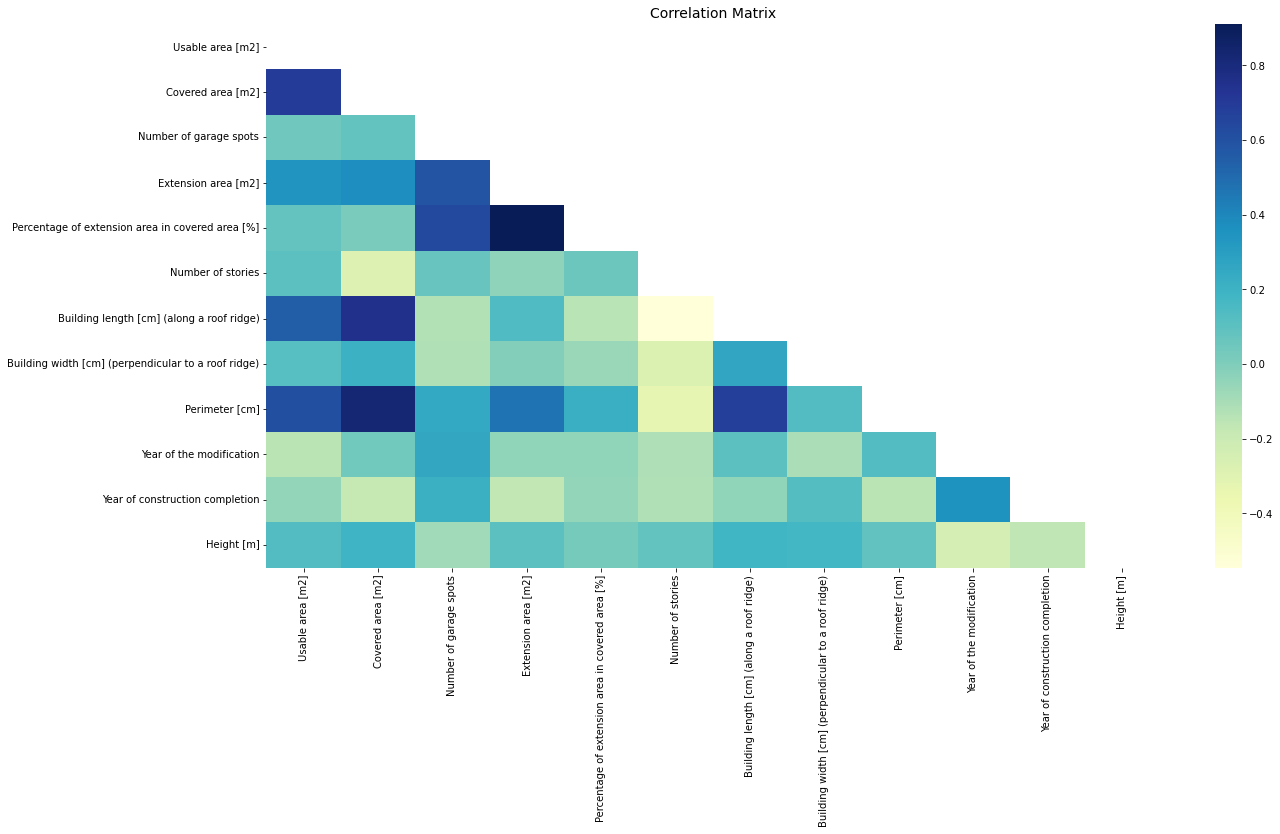

In [14]:
fig, ax = plt.subplots(figsize=(20,10))         
# Imbalanced DataFrame Correlation
corr_df = df1.drop(["Remarks", "No."], axis=1)
corr = corr_df.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax, mask=np.triu(np.ones(shape=corr.shape)).astype(bool))
ax.set_title("Correlation Matrix", fontsize=14)
plt.show()

## Dataset 2 - Known norms
Input data: Varying  
Output: Usable area [m2]

In [15]:
curr_file = data_dir.joinpath("Koszalin_znana_norma.xlsx")

In [16]:
curr_file_dict = pd.read_excel(curr_file, sheet_name=None)
curr_file_dict.keys()

dict_keys(['known_norm'])

In [17]:
dataset_name = "known_norm"
purge_garages = False


curr_df = curr_file_dict[dataset_name]
curr_df["Garage area [m2]"] = curr_df["Garage area [m2]"].replace('unknown', curr_df["Garage area [m2]"].replace('unknown', np.NaN).mean())
curr_df["Number of rooms"] = curr_df["Number of rooms"].replace('unknown', curr_df["Number of rooms"].replace('unknown', np.NaN).mean())
if purge_garages:
    curr_df = curr_df.drop(curr_df[curr_df["Garage area [m2]"] == "unknown"].index)
    curr_df = curr_df.drop(curr_df[curr_df["Garage area [m2]"] > 0].index)
df2 = curr_df.copy()
df2.head(10)

,No.,Source,Garage area [m2],Covered area [m2],Usable area [m2],Height [m],Volume [m3],Number of rooms,Number of stories
0,1,https://polska.geoportal2.pl/map/www/mapa.php?...,33.040000,169.86,143.97,7.49,597.14,4.0,2
1,3,https://polska.geoportal2.pl/map/www/mapa.php?...,0.000000,179.53,157.84,6.00,537.40,6.0,2
2,4,https://polska.geoportal2.pl/map/www/mapa.php?...,23.180000,118.33,105.97,7.63,588.90,5.0,2
3,5,https://polska.geoportal2.pl/map/www/mapa.php?...,23.500000,124.80,148.20,8.43,811.00,7.0,2
4,6,https://polska.geoportal2.pl/map/www/mapa.php?...,0.000000,122.06,158.47,7.80,772.29,6.0,2
5,7,https://polska.geoportal2.pl/map/www/mapa.php?...,0.000000,70.01,53.58,6.25,334.88,4.0,1
6,8,https://polska.geoportal2.pl/map/www/mapa.php?...,38.200000,113.50,136.80,8.22,838.00,6.0,2
7,9,https://polska.geoportal2.pl/map/www/mapa.php?...,0.000000,102.42,104.04,8.13,589.00,5.0,2
8,10,https://polska.geoportal2.pl/map/www/mapa.php?...,5.155185,146.52,171.68,7.74,812.00,6.0,2
9,11,https://polska.geoportal2.pl/map/www/mapa.php?...,5.155185,122.47,177.82,7.29,833.85,5.0,2


In [18]:
df2.describe()

,No.,Garage area [m2],Covered area [m2],Usable area [m2],Height [m],Volume [m3],Number of rooms,Number of stories
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,16.206897,5.155185,129.928966,138.134483,7.625862,671.658276,5.428571,1.827586
std,8.901763,10.979375,34.104742,39.172555,0.866786,202.530128,1.237179,0.384426
min,1.000000,0.000000,66.820000,53.580000,6.000000,334.880000,3.000000,1.000000
25%,9.000000,0.000000,113.500000,104.040000,6.870000,537.400000,5.000000,2.000000
50%,16.000000,0.000000,127.020000,143.970000,7.740000,710.000000,6.000000,2.000000
75%,23.000000,0.000000,154.400000,169.620000,8.400000,811.000000,6.000000,2.000000
max,31.000000,38.200000,187.940000,232.650000,8.770000,1161.480000,9.000000,2.000000


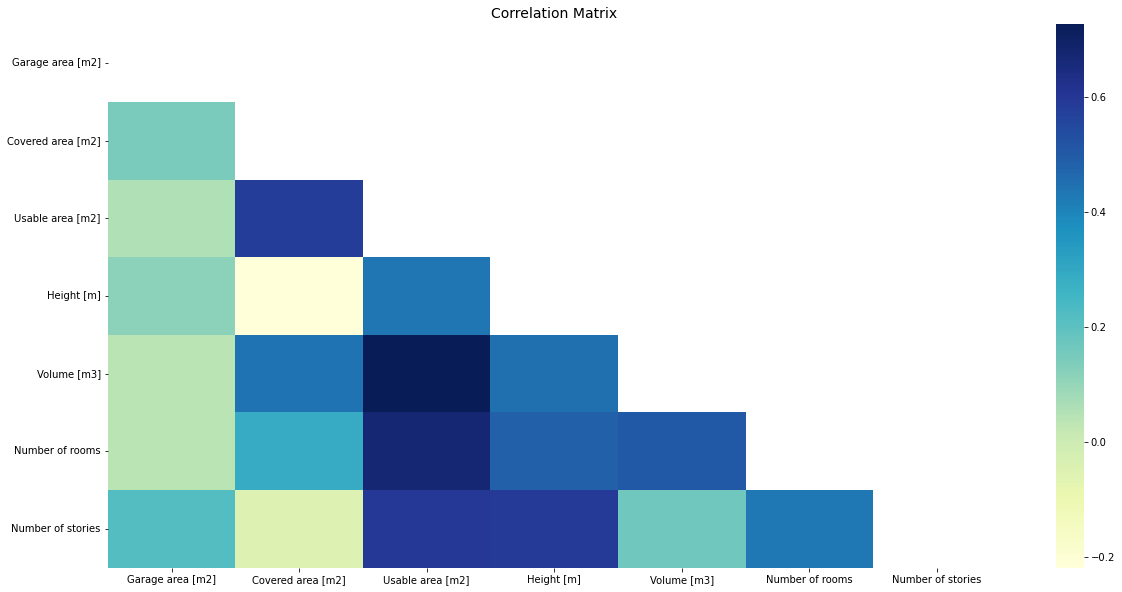

In [19]:
fig, ax = plt.subplots(figsize=(20,10))         
# Imbalanced DataFrame Correlation
corr_df = df2.drop([ "No."], axis=1)
corr = corr_df.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax, mask=np.triu(np.ones(shape=corr.shape)).astype(bool))
ax.set_title("Correlation Matrix", fontsize=14)
plt.show()

# Model Testing

In [20]:
model_dir = Path("./modele/Final_models/Dataset1")
model_dir_2 = Path("./modele/Final_models/Dataset1and2")
model_list = list(model_dir.iterdir())
model_list_2 = list(model_dir_2.iterdir())

In [21]:
for f in model_dir.iterdir():
    print(f)
for f in model_dir_2.iterdir():
    print(f)

modele/Final_models/Dataset1/DNN_lr=0,1_|_λ =0,5_cols=[Covered area [m2], Number of stories]_|_dataset=Without garages or boiler rooms.pt
modele/Final_models/Dataset1/DNN_lr=0,1_|_λ =1,5_cols=[Covered area [m2], Height [m], Number of stories, Height of a knee wall [m]]_|_dataset=Without garages or boiler rooms.pt
modele/Final_models/Dataset1/DNN_lr=0,1_|_λ =0,5_cols=[Covered area [m2], Height [m]]_|_dataset=Without garages or boiler rooms.pt
modele/Final_models/Dataset1/DNN_lr=0,1_|_λ =0,5_cols=[Covered area [m2], Height [m], Number of stories]_|_dataset=Without garages or boiler rooms.pt
modele/Final_models/Dataset1and2/DNN_lr=0,1_|_λ =1,25_cols=[Covered area [m2], Height [m], Number of stories, Height of a knee wall [m]]_|_dataset=Without garages, with boilers.pt
modele/Final_models/Dataset1and2/DNN_lr=0,1_|_λ =1,25_cols=[Covered area [m2], Height [m], Number of stories, Height of a knee wall [m], Perimeter [cm]]_|_dataset=Without garages, with boilers.pt


## Model 1

### Model loading

In [22]:
model_path = model_list[0]
learning_rate=0.1
λ=0.5
used_cols = ["Covered area [m2]", "Number of stories"]
input_size = len(used_cols)
architecture=DeepNet
milestones = [200, 400, 1700, 1900]
arch_params = (input_size, 1, 10)
model = architecture(*arch_params).double()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [23]:
df_norm = wo_garages_boilers_df
np.random.seed(rs)
torch.manual_seed(rs);
df_train_and_val, df_test = train_test_split(df_norm, test_size=0.2, random_state=rs)
df_train, df_val = train_test_split(df_train_and_val, test_size=0.25, random_state=rs)
Y_train = df_train["Usable area [m2]"]
X_train = df_train[used_cols].to_numpy()
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

#### Dataset without known norms

In [24]:
used_ds = df1
X_test = used_ds[used_cols].to_numpy()
Y_test = used_ds["Usable area [m2]"]
X_test = scaler.transform(X_test)
test_features = Variable(torch.from_numpy(X_test))
test_labels = Variable(torch.from_numpy(Y_test.to_numpy()).double())
# Model evaluationb
with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        Y_pred = model(test_features).numpy().reshape(-1)
        df_pred = pd.DataFrame(Y_pred, columns=["Predicted Usable Area [m2]"])
        df_test_viz = used_ds.join(df_pred)
    
df_test_viz["Error"] = np.abs(df_test_viz["Usable area [m2]"] - df_test_viz["Predicted Usable Area [m2]"])

plot_df_summary(df_test_viz)

#### Dataset with known norms

In [25]:
used_ds = df2
X_test = used_ds[used_cols].to_numpy()
Y_test = used_ds["Usable area [m2]"]
X_test = scaler.transform(X_test)
test_features = Variable(torch.from_numpy(X_test))
test_labels = Variable(torch.from_numpy(Y_test.to_numpy()).double())
# Model evaluation
with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        Y_pred = model(test_features).numpy().reshape(-1)
        df_pred = pd.DataFrame(Y_pred, columns=["Predicted Usable Area [m2]"])
        df_test_viz = used_ds.join(df_pred)
    
df_test_viz["Error"] = np.abs(df_test_viz["Usable area [m2]"] - df_test_viz["Predicted Usable Area [m2]"])

plot_df_summary(df_test_viz)

## Model 2

In [26]:
model_list[1]

PosixPath('modele/Final_models/Dataset1/DNN_lr=0,1_|_λ =1,5_cols=[Covered area [m2], Height [m], Number of stories, Height of a knee wall [m]]_|_dataset=Without garages or boiler rooms.pt')

### Model loading

In [27]:
model_path = model_list[1]
learning_rate=0.1
λ=1.5
used_cols = ["Covered area [m2]", "Height [m]", "Number of stories", "Height of a knee wall [m]"]
input_size = len(used_cols)
architecture=DeepNet
milestones = [200, 400, 1700, 1900]
arch_params = (input_size, 1, 30)
model = architecture(*arch_params).double()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [28]:
df_norm = wo_garages_boilers_df
np.random.seed(rs)
torch.manual_seed(rs);
df_train_and_val, df_test = train_test_split(df_norm, test_size=0.2, random_state=rs)
df_train, df_val = train_test_split(df_train_and_val, test_size=0.25, random_state=rs)
Y_train = df_train["Usable area [m2]"]
X_train = df_train[used_cols].to_numpy()
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

#### Dataset without known norms

In [ ]:
used_ds = df1
X_test = used_ds[used_cols].to_numpy()
Y_test = used_ds["Usable area [m2]"]
X_test = scaler.transform(X_test)
test_features = Variable(torch.from_numpy(X_test))
test_labels = Variable(torch.from_numpy(Y_test.to_numpy()).double())
# Model evaluation
with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        Y_pred = model(test_features).numpy().reshape(-1)
        df_pred = pd.DataFrame(Y_pred, columns=["Predicted Usable Area [m2]"])
        df_test_viz = used_ds.join(df_pred)
    
df_test_viz["Error"] = np.abs(df_test_viz["Usable area [m2]"] - df_test_viz["Predicted Usable Area [m2]"])

plot_df_summary(df_test_viz)

#### Dataset with known norms

In [ ]:
used_ds = df2
X_test = used_ds[used_cols].to_numpy()
Y_test = used_ds["Usable area [m2]"]
X_test = scaler.transform(X_test)
test_features = Variable(torch.from_numpy(X_test))
test_labels = Variable(torch.from_numpy(Y_test.to_numpy()).double())
# Model evaluation
with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        Y_pred = model(test_features).numpy().reshape(-1)
        df_pred = pd.DataFrame(Y_pred, columns=["Predicted Usable Area [m2]"])
        df_test_viz = used_ds.join(df_pred)
    
df_test_viz["Error"] = np.abs(df_test_viz["Usable area [m2]"] - df_test_viz["Predicted Usable Area [m2]"])

plot_df_summary(df_test_viz)

## Model 3

In [32]:
model_list[2]

PosixPath('modele/Final_models/Dataset1/DNN_lr=0,1_|_λ =0,5_cols=[Covered area [m2], Height [m]]_|_dataset=Without garages or boiler rooms.pt')

### Model loading

In [33]:
model_path = model_list[2]
learning_rate=0.1
λ=0.5
used_cols = ["Covered area [m2]", "Height [m]"]
input_size = len(used_cols)
architecture=DeepNet
milestones = [200, 400, 1700, 1900]
arch_params = (input_size, 1, 10)
model = architecture(*arch_params).double()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [34]:
df_norm = wo_garages_boilers_df
np.random.seed(rs)
torch.manual_seed(rs);
df_train_and_val, df_test = train_test_split(df_norm, test_size=0.2, random_state=rs)
df_train, df_val = train_test_split(df_train_and_val, test_size=0.25, random_state=rs)
Y_train = df_train["Usable area [m2]"]
X_train = df_train[used_cols].to_numpy()
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

#### Dataset without known norms

In [35]:
used_ds = df1
X_test = used_ds[used_cols].to_numpy()
Y_test = used_ds["Usable area [m2]"]
X_test = scaler.transform(X_test)
test_features = Variable(torch.from_numpy(X_test))
test_labels = Variable(torch.from_numpy(Y_test.to_numpy()).double())
# Model evaluation
with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        Y_pred = model(test_features).numpy().reshape(-1)
        df_pred = pd.DataFrame(Y_pred, columns=["Predicted Usable Area [m2]"])
        df_test_viz = used_ds.join(df_pred)
    
df_test_viz["Error"] = np.abs(df_test_viz["Usable area [m2]"] - df_test_viz["Predicted Usable Area [m2]"])

plot_df_summary(df_test_viz)

R^2 = -0.40 
Mean Absolute Error = 24.04
Median Absolute Error = 14.45
Max Error = 223.55
Min Error = 0.22
Median Absolute Percentage Error = 0.16


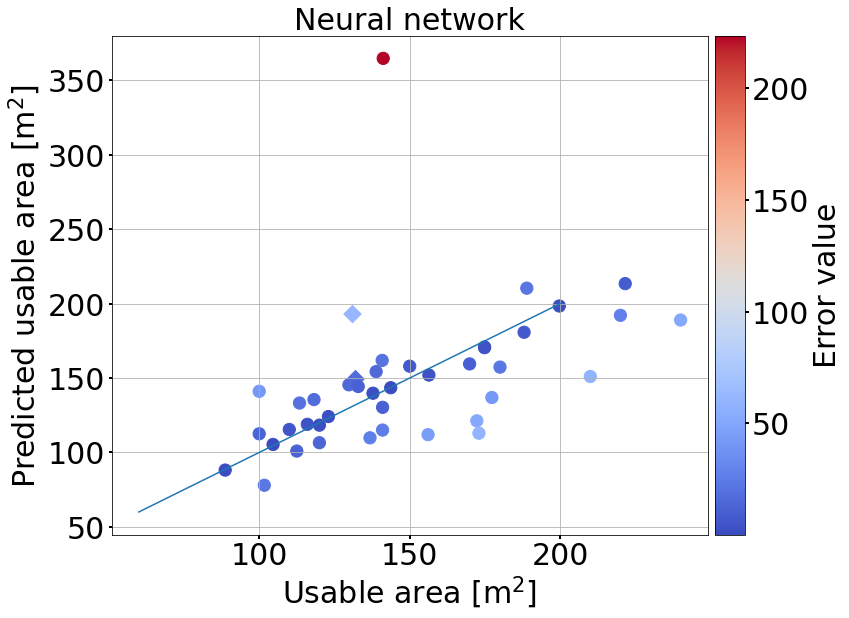

In [36]:
models_comparison_figure(df_test_viz)

#### Dataset with known norms

In [37]:
used_ds = df2
X_test = used_ds[used_cols].to_numpy()
Y_test = used_ds["Usable area [m2]"]
X_test = scaler.transform(X_test)
test_features = Variable(torch.from_numpy(X_test))
test_labels = Variable(torch.from_numpy(Y_test.to_numpy()).double())
# Model evaluation
with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        Y_pred = model(test_features).numpy().reshape(-1)
        df_pred = pd.DataFrame(Y_pred, columns=["Predicted Usable Area [m2]"])
        df_test_viz = used_ds.join(df_pred)
    
df_test_viz["Error"] = np.abs(df_test_viz["Usable area [m2]"] - df_test_viz["Predicted Usable Area [m2]"])

df_3 = df_test_viz.copy()

plot_df_summary(df_test_viz)

R^2 = 0.62 
Mean Absolute Error = 17.29
Median Absolute Error = 12.44
Max Error = 63.50
Min Error = 0.21
Median Absolute Percentage Error = 0.15


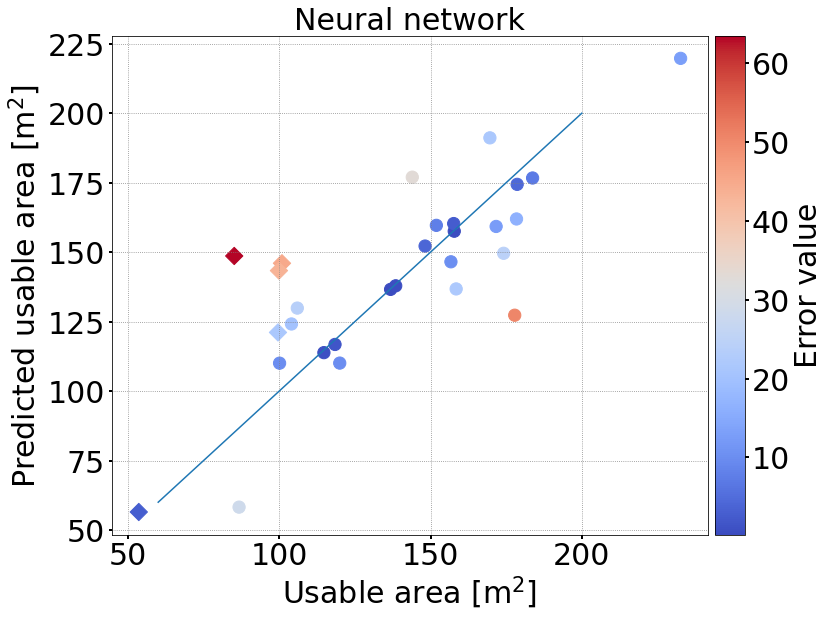

In [38]:
models_comparison_figure(df_test_viz)

## Model 4

In [39]:
model_list[3]

PosixPath('modele/Final_models/Dataset1/DNN_lr=0,1_|_λ =0,5_cols=[Covered area [m2], Height [m], Number of stories]_|_dataset=Without garages or boiler rooms.pt')

### Model loading

In [40]:
model_path = model_list[3]
learning_rate=0.1
λ=0.5
used_cols = ["Covered area [m2]", "Height [m]", "Number of stories"]
input_size = len(used_cols)
architecture=DeepNet
milestones = [200, 400, 1700, 1900]
arch_params = (input_size, 1, 10)
model = architecture(*arch_params).double()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [41]:
df_norm = wo_garages_boilers_df
np.random.seed(rs)
torch.manual_seed(rs);
df_train_and_val, df_test = train_test_split(df_norm, test_size=0.2, random_state=rs)
df_train, df_val = train_test_split(df_train_and_val, test_size=0.25, random_state=rs)
Y_train = df_train["Usable area [m2]"]
X_train = df_train[used_cols].to_numpy()
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

#### Dataset without unknown norms

In [42]:
used_ds = df1
X_test = used_ds[used_cols].to_numpy()
Y_test = used_ds["Usable area [m2]"]
X_test = scaler.transform(X_test)
test_features = Variable(torch.from_numpy(X_test))
test_labels = Variable(torch.from_numpy(Y_test.to_numpy()).double())
# Model evaluation
with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        Y_pred = model(test_features).numpy().reshape(-1)
        df_pred = pd.DataFrame(Y_pred, columns=["Predicted Usable Area [m2]"])
        df_test_viz = used_ds.join(df_pred)
    
df_test_viz["Error"] = np.abs(df_test_viz["Usable area [m2]"] - df_test_viz["Predicted Usable Area [m2]"])

plot_df_summary(df_test_viz)

R^2 = 0.17 
Mean Absolute Error = 21.33
Median Absolute Error = 14.64
Max Error = 158.75
Min Error = 0.65
Median Absolute Percentage Error = 0.15


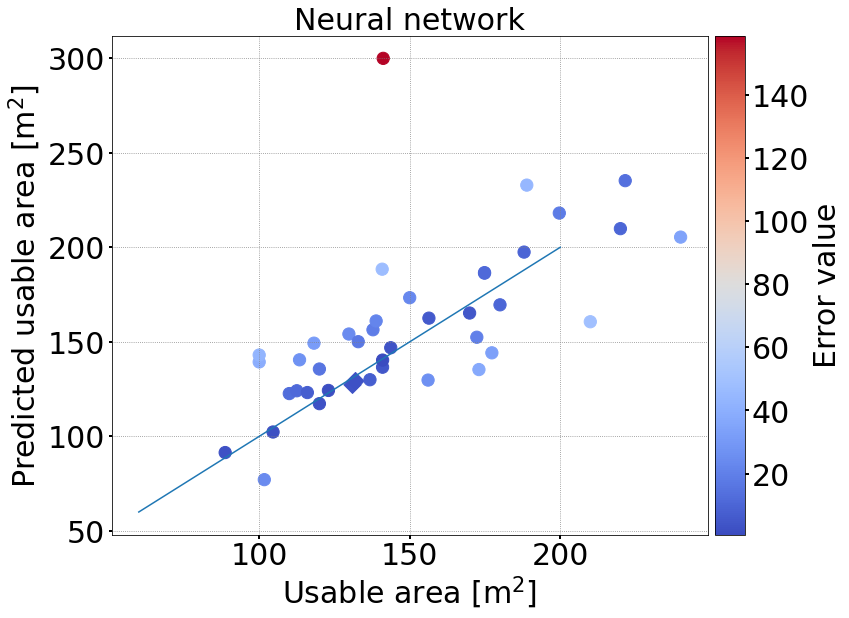

In [43]:
models_comparison_figure(df_test_viz)

#### Dataset with known norms

In [44]:
used_ds = df2
X_test = used_ds[used_cols].to_numpy()
Y_test = used_ds["Usable area [m2]"]
X_test = scaler.transform(X_test)
test_features = Variable(torch.from_numpy(X_test))
test_labels = Variable(torch.from_numpy(Y_test.to_numpy()).double())
# Model evaluation
with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        Y_pred = model(test_features).numpy().reshape(-1)
        df_pred = pd.DataFrame(Y_pred, columns=["Predicted Usable Area [m2]"])
        df_test_viz = used_ds.join(df_pred)
    
df_test_viz["Error"] = np.abs(df_test_viz["Usable area [m2]"] - df_test_viz["Predicted Usable Area [m2]"])

df_4 = df_test_viz.copy()

plot_df_summary(df_test_viz)

R^2 = 0.56 
Mean Absolute Error = 19.40
Median Absolute Error = 15.42
Max Error = 63.29
Min Error = 0.03
Median Absolute Percentage Error = 0.15


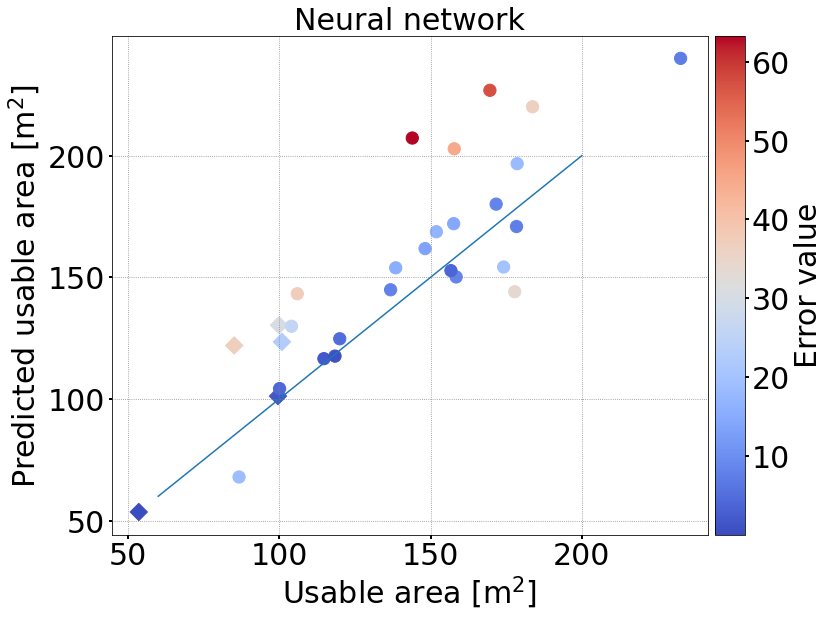

In [45]:
models_comparison_figure(df_test_viz)

## Model 4 and 5 comparison

In [76]:
def models_comparison_figure_ab(df_reg, df_nn, plot_name = "NN_VS_NN.pdf"):
    fig, axs = plt.subplots(1, 2, figsize=(25, 10))
    plt.tight_layout(pad=10, h_pad=5, w_pad=0.2)
    fs = 30
    fs_inset = 20
    lw = 3
    colormap = "coolwarm"



    axs[0].set_title("(a)\nInput features: $A_C$, $H$ ", fontsize=fs, y=1.01)
    axs[0].plot(np.linspace(60, 250), np.linspace(60, 250))
    # scat1 = axs[0].scatter(df_reg["Usable area [m2]"], df_reg["Predicted Usable Area [m2]"], c=df_reg.Error, cmap="coolwarm")
    norm = plt.Normalize(np.min(df_reg.Error), np.max(df_reg.Error))
    df_1s = df_reg.loc[df_reg["Number of stories"] == 1.0]
    df_2s = df_reg.loc[df_reg["Number of stories"] == 2.0]
    axs[0].scatter(df_1s["Usable area [m2]"], df_1s["Predicted Usable Area [m2]"], c=df_1s.Error, cmap=colormap, marker='D', norm=norm, s=10*fs, edgecolor='b')
    axs[0].scatter(df_2s["Usable area [m2]"], df_2s["Predicted Usable Area [m2]"], c=df_2s.Error, cmap=colormap, marker='o', norm=norm, s=10*fs, edgecolor='b')
    """
    axs[0].text(0.03, 0.96, "R^2 = {:.2f} \nMean Absolute Error = {:.2f}\nMedian Absolute Error = {:.2f}\nMax Error = {:.2f}\nMin Error = {:.2f}\nMedian Absolute Percentage Error = {:.2f}".format(
                                                                                sklearn.metrics.r2_score(df_reg["Usable area [m2]"].to_numpy(), df_reg["Predicted Usable Area [m2]"].to_numpy()), 
                                                                                sklearn.metrics.mean_absolute_error(df_reg["Usable area [m2]"].to_numpy(), df_reg["Predicted Usable Area [m2]"].to_numpy()),
                                                                                sklearn.metrics.median_absolute_error(df_reg["Usable area [m2]"].to_numpy(), df_reg["Predicted Usable Area [m2]"].to_numpy()),
                                                                                sklearn.metrics.max_error(df_reg["Usable area [m2]"].to_numpy(), df_reg["Predicted Usable Area [m2]"].to_numpy()),
                                                                                np.abs(np.min(df_reg["Error"])),
                                                                                sklearn.metrics.mean_absolute_percentage_error(df_reg["Usable area [m2]"].to_numpy(), df_reg["Predicted Usable Area [m2]"].to_numpy())
                                                                                ), bbox=dict(boxstyle="round", fc="lightsalmon", ec="coral", lw=2), horizontalalignment='left', verticalalignment='top', transform=axs[0].transAxes, fontsize=fs_inset);
    """
    divider = make_axes_locatable(axs[0])
    # cax = divider.append_axes("right", size="5%", pad=0.1)
    # cbar = plt.colorbar(scat1, cax=cax)
    # cbar.set_label('Error value', fontsize=fs)

    axs[0].set_xlabel(r"Usable area [m$^2$]", fontsize=fs)
    axs[0].set_ylabel(r"Predicted usable area [m$^2$]", fontsize=fs)

    axs[1].set_title("(b)\nInput features: $A_C$, $H$, $N_S$", fontsize=fs, y=1.01)
    axs[1].plot(np.linspace(60, 250), np.linspace(60, 250))
    scat2 = axs[1].scatter(df_nn["Usable area [m2]"], df_nn["Predicted Usable Area [m2]"], c=df_nn.Error, cmap=colormap, marker="")
    norm = plt.Normalize(np.min(df_nn.Error), np.max(df_nn.Error))
    df_1s = df_nn.loc[df_nn["Number of stories"] == 1.0]
    df_2s = df_nn.loc[df_nn["Number of stories"] == 2.0]
    axs[1].scatter(df_1s["Usable area [m2]"], df_1s["Predicted Usable Area [m2]"], c=df_1s.Error, cmap=colormap, marker="D", norm=norm, s=10*fs, edgecolor='b')
    axs[1].scatter(df_2s["Usable area [m2]"], df_2s["Predicted Usable Area [m2]"], c=df_2s.Error, cmap=colormap, marker="o", norm=norm, s=10*fs, edgecolor='b')
    """
    axs[1].text(0.03, 0.96, "R^2 = {:.2f} \nMean Absolute Error = {:.2f}\nMedian Absolute Error = {:.2f}\nMax Error = {:.2f}\nMin Error = {:.2f}\nMedian Absolute Percentage Error = {:.2f}".format(
                                                                                sklearn.metrics.r2_score(df_nn["Usable area [m2]"].to_numpy(), df_nn["Predicted Usable Area [m2]"].to_numpy()), 
                                                                                sklearn.metrics.mean_absolute_error(df_nn["Usable area [m2]"].to_numpy(), df_nn["Predicted Usable Area [m2]"].to_numpy()),
                                                                                sklearn.metrics.median_absolute_error(df_nn["Usable area [m2]"].to_numpy(), df_nn["Predicted Usable Area [m2]"].to_numpy()),
                                                                                sklearn.metrics.max_error(df_nn["Usable area [m2]"].to_numpy(), df_nn["Predicted Usable Area [m2]"].to_numpy()),
                                                                                np.abs(np.min(df_nn["Error"])),
                                                                                sklearn.metrics.mean_absolute_percentage_error(df_nn["Usable area [m2]"].to_numpy(), df_nn["Predicted Usable Area [m2]"].to_numpy())
                                                                                ), bbox=dict(boxstyle="round", fc="lightsalmon", ec="coral", lw=2), horizontalalignment='left', verticalalignment='top', transform=axs[1].transAxes, fontsize=fs_inset);
    """
    axs[1].set_xlabel(r"Usable area [m$^2$]", fontsize=fs)

    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(scat2, cax=cax)
    cbar.set_label('Error value', fontsize=fs)
    cax.tick_params(axis='both', which='major', labelsize=fs, width=2)


    axs[1].set_yticklabels([])

    for ax in axs.flatten():
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
            ax.spines[axis].set_zorder(0)

    for ax in axs.flatten():
        ax.tick_params(axis='both', which='major', labelsize=fs, width=2)

    for ax in axs.flatten():
        ax.grid(True)

    plt.rc('grid', linestyle=":", color='gray')

    plt.savefig(plot_name)
    plt.show()

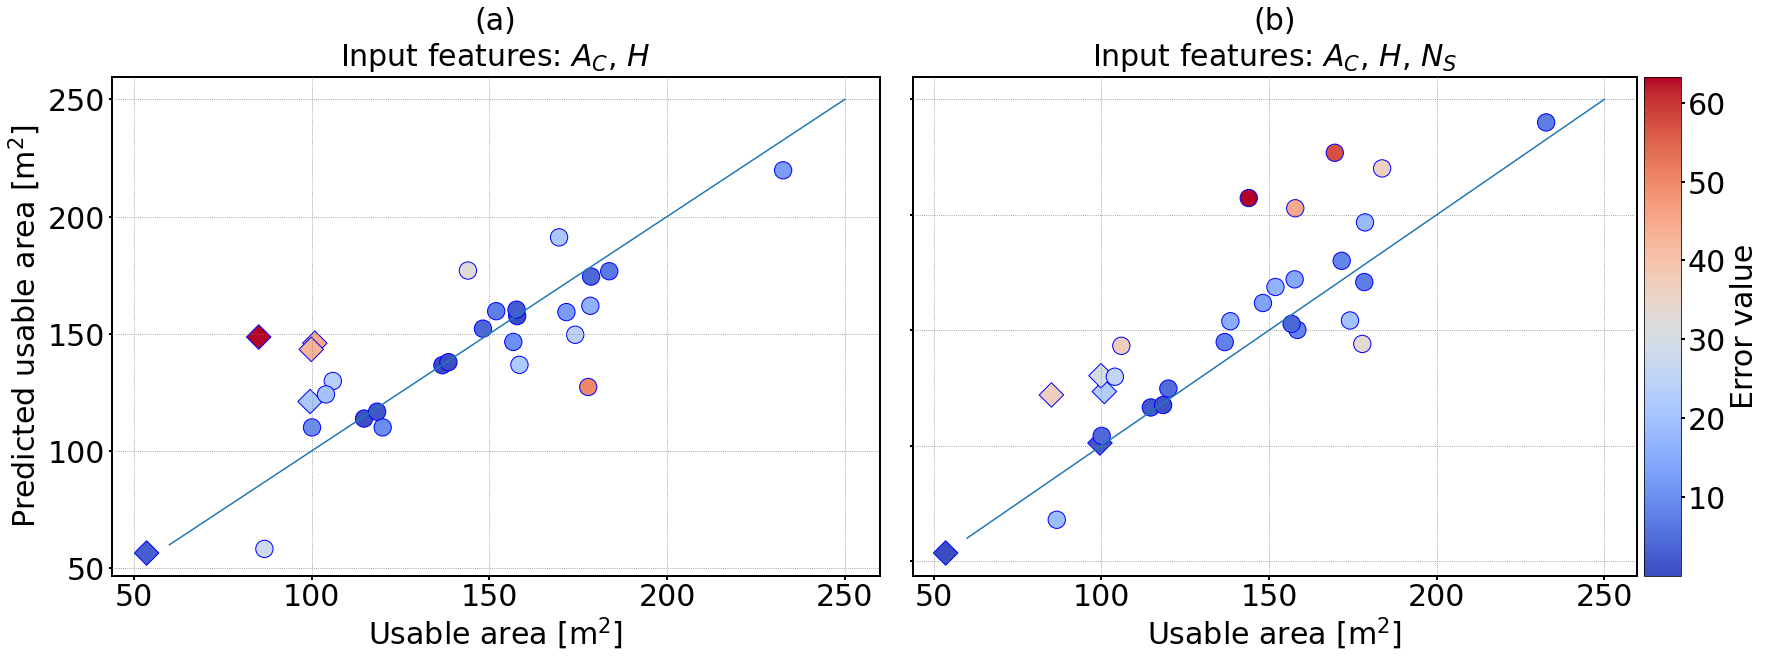

In [77]:
models_comparison_figure_ab(df_3, df_4)

## Model 5

In [ ]:
model_list_2[0]

PosixPath('modele/Final_models/Dataset1and2/DNN_lr=0,1_|_λ =1,25_cols=[Covered area [m2], Height [m], Number of stories, Height of a knee wall [m]]_|_dataset=Without garages, with boilers.pt')

### Model loading

In [ ]:
model_path = model_list_2[0]
learning_rate=0.1
λ=1.25
used_cols = ["Covered area [m2]", "Number of stories", "Height [m]", "Height of a knee wall [m]"]
input_size = len(used_cols)
architecture=DeepNet
milestones = [200, 400, 1700, 1900]
arch_params = (input_size, 1, 50)
model = architecture(*arch_params).double()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
df_norm = ds_1_2
np.random.seed(rs)
torch.manual_seed(rs);
df_train_and_val, df_test = train_test_split(df_norm, test_size=0.2, random_state=rs)
df_train, df_val = train_test_split(df_train_and_val, test_size=0.25, random_state=rs)
Y_train = df_train["Usable area [m2]"]
X_train = df_train[used_cols].to_numpy()
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

#### Dataset without known norms

In [ ]:
used_ds = df1
X_test = used_ds[used_cols].to_numpy()
Y_test = used_ds["Usable area [m2]"]
X_test = scaler.transform(X_test)
test_features = Variable(torch.from_numpy(X_test))
test_labels = Variable(torch.from_numpy(Y_test.to_numpy()).double())
# Model evaluation
with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        Y_pred = model(test_features).numpy().reshape(-1)
        df_pred = pd.DataFrame(Y_pred, columns=["Predicted Usable Area [m2]"])
        df_test_viz = used_ds.join(df_pred)
    
df_test_viz["Error"] = np.abs(df_test_viz["Usable area [m2]"] - df_test_viz["Predicted Usable Area [m2]"])

plot_df_summary(df_test_viz)

#### Dataset with known norms

In [ ]:
used_ds = df2
X_test = used_ds[used_cols].to_numpy()
Y_test = used_ds["Usable area [m2]"]
X_test = scaler.transform(X_test)
test_features = Variable(torch.from_numpy(X_test))
test_labels = Variable(torch.from_numpy(Y_test.to_numpy()).double())
# Model evaluation
with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        Y_pred = model(test_features).numpy().reshape(-1)
        df_pred = pd.DataFrame(Y_pred, columns=["Predicted Usable Area [m2]"])
        df_test_viz = used_ds.join(df_pred)
    
df_test_viz["Error"] = np.abs(df_test_viz["Usable area [m2]"] - df_test_viz["Predicted Usable Area [m2]"])

plot_df_summary(df_test_viz)

## Model 6

In [ ]:
model_list_2[1]

PosixPath('modele/Final_models/Dataset1and2/DNN_lr=0,1_|_λ =1,25_cols=[Covered area [m2], Height [m], Number of stories, Height of a knee wall [m], Perimeter [cm]]_|_dataset=Without garages, with boilers.pt')

### Model loading

In [ ]:
model_path = model_list_2[1]
learning_rate=0.1
λ=1.5
used_cols = ["Covered area [m2]", "Height [m]", "Number of stories", "Height of a knee wall [m]", "Perimeter [cm]"]
input_size = len(used_cols)
architecture=DeepNet
milestones = [200, 400, 1700, 1900]
arch_params = (input_size, 1, 50)
model = architecture(*arch_params).double()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
df_norm = ds_1_2
np.random.seed(rs)
torch.manual_seed(rs);
df_train_and_val, df_test = train_test_split(df_norm, test_size=0.2, random_state=rs)
df_train, df_val = train_test_split(df_train_and_val, test_size=0.25, random_state=rs)
Y_train = df_train["Usable area [m2]"]
X_train = df_train[used_cols].to_numpy()
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

#### Dataset without known norms

In [ ]:
used_ds = df1
X_test = used_ds[used_cols].to_numpy()
Y_test = used_ds["Usable area [m2]"]
X_test = scaler.transform(X_test)
test_features = Variable(torch.from_numpy(X_test))
test_labels = Variable(torch.from_numpy(Y_test.to_numpy()).double())
# Model evaluation
with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        Y_pred = model(test_features).numpy().reshape(-1)
        df_pred = pd.DataFrame(Y_pred, columns=["Predicted Usable Area [m2]"])
        df_test_viz = used_ds.join(df_pred)
    
df_test_viz["Error"] = np.abs(df_test_viz["Usable area [m2]"] - df_test_viz["Predicted Usable Area [m2]"])

plot_df_summary(df_test_viz)

#### Dataset with known norms

In [ ]:
used_ds = df2
X_test = used_ds[used_cols].to_numpy()
Y_test = used_ds["Usable area [m2]"]
X_test = scaler.transform(X_test)
test_features = Variable(torch.from_numpy(X_test))
test_labels = Variable(torch.from_numpy(Y_test.to_numpy()).double())
# Model evaluation
with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        Y_pred = model(test_features).numpy().reshape(-1)
        df_pred = pd.DataFrame(Y_pred, columns=["Predicted Usable Area [m2]"])
        df_test_viz = used_ds.join(df_pred)
    
df_test_viz["Error"] = np.abs(df_test_viz["Usable area [m2]"] - df_test_viz["Predicted Usable Area [m2]"])

plot_df_summary(df_test_viz)